<a href="https://colab.research.google.com/github/drmsbgr/employee-attrition/blob/main/Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ibm-hr-analytics-attrition-dataset' dataset.
Path to dataset files: /kaggle/input/ibm-hr-analytics-attrition-dataset


Veri Seti Boyutu: (1470, 35)

--- İlk 5 Satır ---


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2



--- Eksik Veri Sayısı ---
0


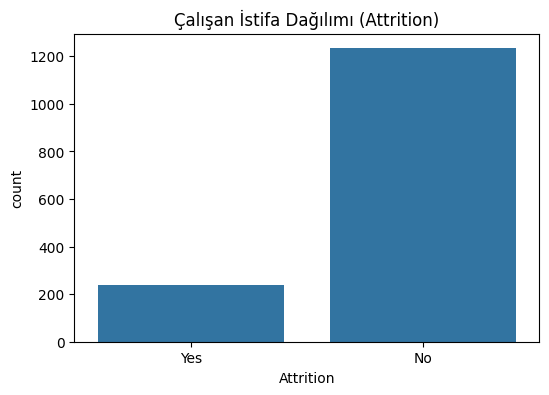

In [ ]:
# Gerekli Kütüphaneleri Yükleyelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Veriyi Yükleme (Colab'in sol panelindeki dosya simgesine tıkla ve csv dosyanı oraya sürükle)
# Dosya isminin doğru olduğundan emin ol
df = pd.read_csv(path+'/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# 2. Veriye İlk Bakış
print("Veri Seti Boyutu:", df.shape)
print("\n--- İlk 5 Satır ---")
display(df.head())

# 3. Eksik Veri Kontrolü
print("\n--- Eksik Veri Sayısı ---")
print(df.isnull().sum().sum()) # IBM verisi genelde temizdir, 0 çıkması lazım.

# 4. Hedef Değişken Analizi (Attrition: Yes/No)
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition', data=df)
plt.title('Çalışan İstifa Dağılımı (Attrition)')
plt.show()

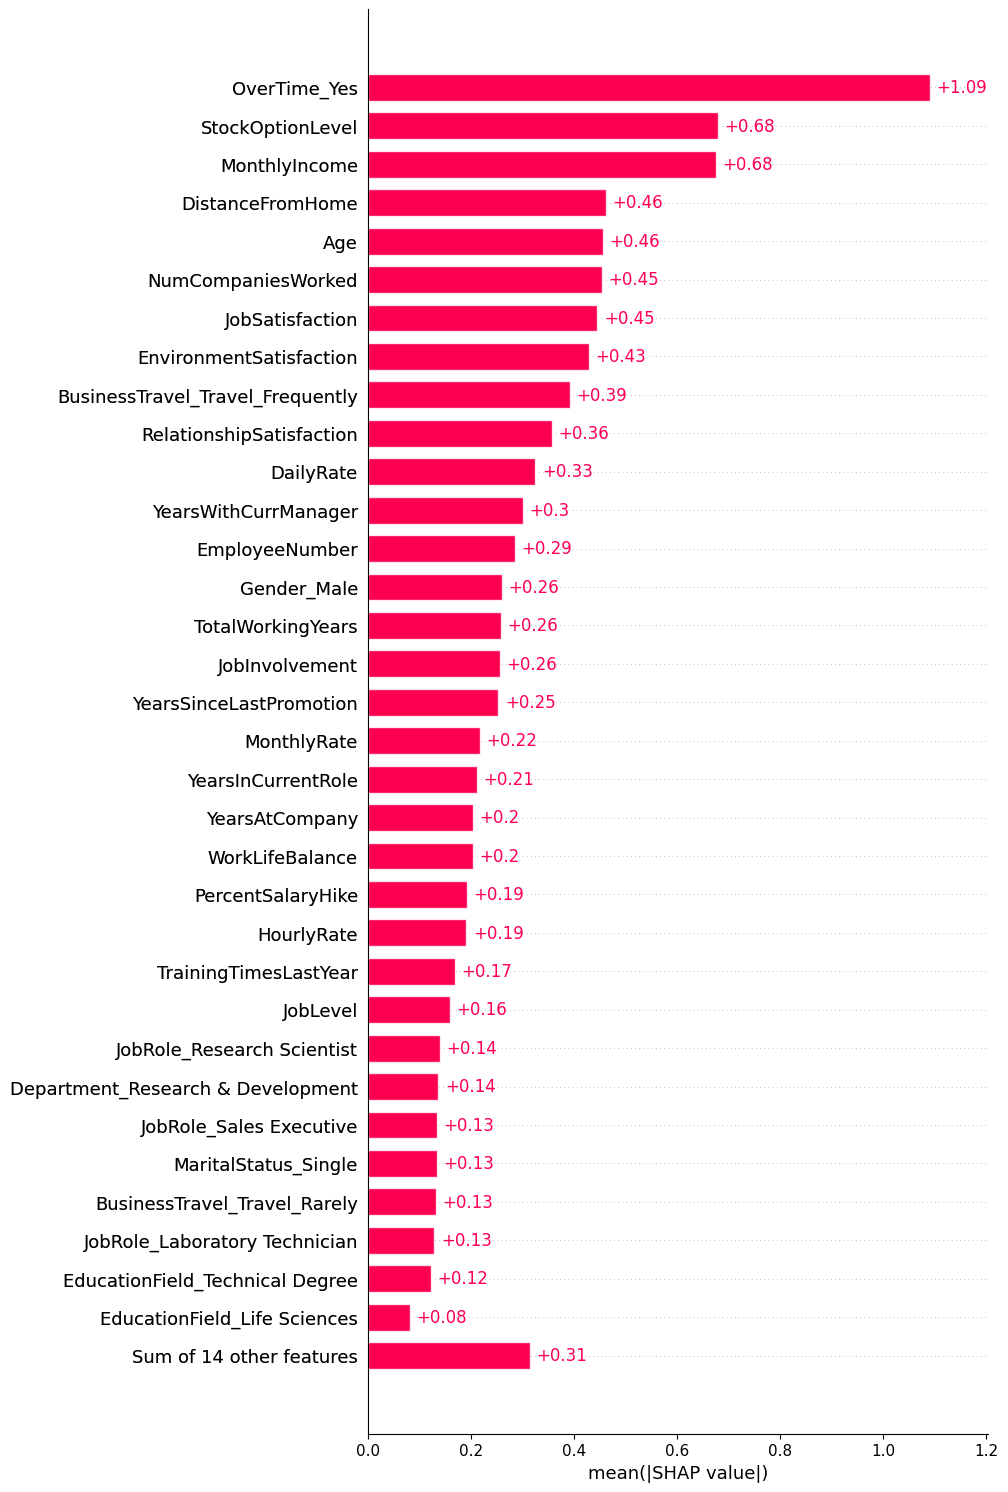

In [53]:
import pandas as pd
import xgboost as xgb
import shap

# Veriyi hazırlama (Kategorik değişkenleri sayısallaştırma)
df_other = pd.get_dummies(df, drop_first=True)
X = df_other.drop('Attrition_Yes', axis=1)
y = df_other['Attrition_Yes']

# Model eğitimi
model = xgb.XGBClassifier().fit(X, y)

# SHAP Değerlerinin Hesaplanması
explainer = shap.TreeExplainer(model)
shap_values_all = explainer(X)
shap.plots.bar(shap_values_all, max_display=34)

1D CNN

In [58]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# --- 1. VERİ HAZIRLAMA ---
# df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv') # Yolunuzu kontrol edin

selected_features = ['OverTime', 'MonthlyIncome', 'TotalWorkingYears', 'DistanceFromHome', 'Age', 'MaritalStatus', 'StockOptionLevel', 'NumCompaniesWorked']

df_final = df[selected_features + ['Attrition']].copy()
df_final['OverTime'] = df_final['OverTime'].map({'Yes': 1, 'No': 0})
df_final['Attrition'] = df_final['Attrition'].map({'Yes': 1, 'No': 0})
marital_map = {'Divorced': 0, 'Married': 1, 'Single': 2}
df_final['MaritalStatus'] = df_final['MaritalStatus'].map(marital_map)

X = df_final[selected_features]
y = df_final['Attrition']

# Veriyi bölme (Stratify kullanarak sınıfları dengeli dağıtıyoruz)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tensörlere dönüştürme [Batch, Channels, Length]
X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(2)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(2)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# --- 2. OPTİMİZE EDİLMİŞ CNN MİMARİSİ ---
class OptimizedCNN(nn.Module):
    def __init__(self, input_dim):
        super(OptimizedCNN, self).__init__()
        # 1D Conv Katmanları
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(128)

        # Global Pooling (Özellikleri özetler)
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Yoğun Katmanlar (Sınıflandırma)
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.4) # %40 ezberleme önleyici
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Evrişim bloğu
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(2)

        # Sınıflandırma bloğu
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model_cnn = OptimizedCNN(len(selected_features))

# --- 3. KAYIP VE OPTİMİZASYON ---
# Sınıf ağırlığı ekleme (İstifa edenlerin sayısının azlığını telafi eder)
# Genelde (Negatif Örnek / Pozitif Örnek) oranı kullanılır.
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model_cnn.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# --- 4. EĞİTİM DÖNGÜSÜ ---
epochs = 3000
best_acc = 0
patience_counter = 0
early_stop_limit = 30

for epoch in range(epochs):
    model_cnn.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Her epoch sonunda test başarısını kontrol et
    model_cnn.eval()
    with torch.no_grad():
        test_preds = (model_cnn(X_test_tensor) > 0.5).float()
        acc = (test_preds == y_test_tensor).sum().item() / y_test_tensor.size(0)

    scheduler.step(total_loss) # Öğrenme hızını güncelle

    # En iyi modeli kaydet (Early Stopping Mantığı)
    if acc > best_acc:
        best_acc = acc
        patience_counter = 0
        torch.save(model_cnn.state_dict(), 'optimized_cnn.pt')
    else:
        patience_counter += 1

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Test Acc: %{acc*100:.2f}")

    if patience_counter >= early_stop_limit:
        print(f"Early Stopping! En İyi Doğruluk: %{best_acc*100:.2f}")
        break

# --- 5. SONUÇLARI KARŞILAŞTIRMAYA EKLEME ---
model_cnn.load_state_dict(torch.load('optimized_cnn.pt'))
model_cnn.eval()
with torch.no_grad():
    final_preds = (model_cnn(X_test_tensor) > 0.5).float().numpy()
    cnn_final_acc = (final_preds == y_test.values.reshape(-1, 1)).mean()

print(f"\nYeni CNN Doğruluk Oranı: %{cnn_final_acc*100:.2f}")

Epoch 20, Loss: 0.3043, Test Acc: %84.35
Early Stopping! En İyi Doğruluk: %86.39

Yeni CNN Doğruluk Oranı: %86.39


MODEL KARŞILAŞTIRMASI

--- Model Sonuçları ---
Logistic Regression Doğruluk Oranı: %85.37
Support Vector Machine Doğruluk Oranı: %85.03
K-Nearest Neighbors Doğruluk Oranı: %82.65
Random Forest Doğruluk Oranı: %83.33
CNN (1D Conv) Doğruluk Oranı: %86.39


/tmp/ipython-input-3494499236.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_results.keys()), y=list(sorted_results.values()), palette="magma")


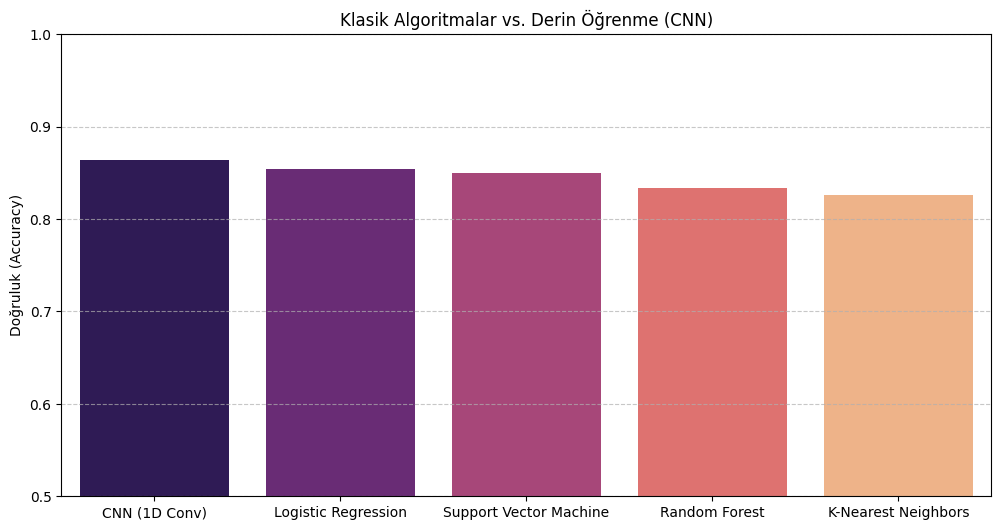

In [59]:
import torch

# 1. Modelleri Tanımlama (Klasik Modeller)
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True), # Olasılık için True yaptık
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# 2. Sonuçlar için Sözlük
results = {}

# 3. Klasik Modelleri Eğitme ve Test Etme
print("--- Model Sonuçları ---")
for name, model in models.items():
    if name == "Random Forest":
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Doğruluk Oranı: %{acc*100:.2f}")

# 4. CNN MODELİNİ TEST ETME VE EKLEME
model_cnn.eval() # Modeli değerlendirme moduna al
with torch.no_grad():
    # Test verisini CNN formatına getir (Batch, Features, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(2)

    # Tahmin yap ve 0.5 eşiğine göre sınıfa çevir
    cnn_outputs = model_cnn(X_test_tensor)
    cnn_preds = (cnn_outputs > 0.5).float().numpy()

cnn_acc = accuracy_score(y_test, cnn_preds)
results["CNN (1D Conv)"] = cnn_acc
print(f"CNN (1D Conv) Doğruluk Oranı: %{cnn_acc*100:.2f}")

# 5. Sonuçları Görselleştirme
plt.figure(figsize=(12, 6))
# Sonuçları başarı sırasına göre dizmek grafiği daha şık gösterir
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(sorted_results.keys()), y=list(sorted_results.values()), palette="magma")
plt.ylim(0.5, 1.0) # Farkları net görmek için
plt.title("Klasik Algoritmalar vs. Derin Öğrenme (CNN)")
plt.ylabel("Doğruluk (Accuracy)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

FRONTEND

In [ ]:
!pip install gradio

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import gradio as gr
import numpy as np

# --- 3. GÜNCELLENMİŞ TAHMİN FONKSİYONU (CNN İÇİN) ---
def istifa_tahmini_cnn(overtime, income, working_years, distance, age, marital, stock_option,num_companies):
    # 1. Girişleri sayısallaştır
    ot_numeric = 1 if overtime == "Evet" else 0
    marital_numeric = marital_map[marital]

    # 2. Giriş verisini liste haline getir
    input_data = np.array([[
        ot_numeric, income, working_years,
        distance, age, marital_numeric, stock_option,num_companies
    ]])

    # 3. ÖNEMLİ: Eğitimde kullanılan scaler ile veriyi ölçeklendir
    input_scaled = scaler.transform(input_data)

    # 4. CNN formatına getir: [Batch=1, Channels=7, Length=1]
    input_tensor = torch.FloatTensor(input_scaled).unsqueeze(2)

    # 5. Tahmin Yap
    model_cnn.eval()
    with torch.no_grad():
        tahmin_olasiliğı = model_cnn(input_tensor).item()

    risk_yuzdesi = round(tahmin_olasiliğı * 100, 2)

    # Sonuç mesajı
    if risk_yuzdesi > 60:
        return f"🚨 CNN KRİTİK RİSK: %{risk_yuzdesi}\nAcil aksiyon planı oluşturulmalı."
    elif risk_yuzdesi > 35:
        return f"⚠️ CNN ORTA RİSK: %{risk_yuzdesi}\nÇalışan bağlılığı düşük, görüşme önerilir."
    else:
        return f"✅ CNN DÜŞÜK RİSK: %{risk_yuzdesi}\nÇalışan aidiyeti yüksek görünüyor."

# --- 4. GRADIO ARAYÜZÜ ---
arayuz = gr.Interface(
    fn=istifa_tahmini_cnn, # Fonksiyon ismini güncelledik
    inputs=[
        gr.Dropdown(["Evet", "Hayır"], label="Fazla Mesai Yapıyor mu? (OverTime)"),
        gr.Slider(500, 200000, label="Aylık Gelir (MonthlyIncome)"),
        gr.Slider(0, 40, label="Toplam Çalışma Yılı (TotalWorkingYears)"),
        gr.Slider(1, 30, label="Eve Uzaklık - KM (DistanceFromHome)"),
        gr.Slider(18, 60, label="Yaşı (Age)"),
        gr.Dropdown(["Single", "Married", "Divorced"], label="Medeni Durum (MaritalStatus)"),
        gr.Slider(0, 3, step=1, label="Hisse Opsiyon Seviyesi (StockOptionLevel)"),
        gr.Slider(0, 10, step=1, label="Daha Önce Çalıştığı Şirket Sayısı (NumCompaniesWorked)")
    ],
    outputs=gr.Textbox(label="CNN Derin Öğrenme Analiz Sonucu"),
    title="🚀 İK Analitiği: CNN Tabanlı İstifa Tahmin Sistemi",
    description="Bu sistem arka planda 1D Convolutional Neural Network (CNN) kullanarak çalışanın verilerini analiz eder.",
    theme="soft"
)

if __name__ == "__main__":
    arayuz.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1d4024312548fb584f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
